In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
import tensorflow as tf

In [3]:
import tensorflow as tf
import numpy as np

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
print(train_x.shape, train_y.shape)
print(train_x.dtype, train_y.dtype)

train_x = train_x.astype(np.float32) / 255.0
test_x = test_x.astype(np.float32) / 255.0

train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28) (60000,)
uint8 uint8
(60000, 10) float32
(10000, 10) float32


In [4]:
class CurricularFaceLoss(tf.keras.losses.Loss):
    def __init__(self, scale=30, margin=0.5, alpha=0.99, name="CurricularFaceLoss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = scale
        self.margin = margin
        self.alpha = alpha
        self.t = tf.Variable(0.)
        self.eps = 1e-7
    
    def positive_forward(self, y_logit):
        cosine_sim = y_logit 
        theta_margin = tf.math.acos(cosine_sim) + self.margin
        y_logit_pos = tf.math.cos(theta_margin)
        return y_logit_pos
    
    def negative_forward(self, y_logit_pos_masked, y_logit):
        hard_sample_mask = y_logit_pos_masked < y_logit # (N, n_classes)
        y_logit_neg = tf.where(hard_sample_mask, tf.square(y_logit)+self.t*y_logit, y_logit)
        return y_logit_neg
    
    def forward(self, y_true, y_logit):
        y_logit = tf.clip_by_value(y_logit, -1.0+self.eps, 1.0-self.eps)
        y_logit_masked = tf.expand_dims(tf.reduce_sum(y_true*y_logit, axis=1), axis=1) # (N, 1)
        y_logit_pos_masked = self.positive_forward(y_logit_masked) # (N, 1)
        y_logit_neg = self.negative_forward(y_logit_pos_masked, y_logit) # (N, n_classes)
        # update t
        r = tf.reduce_mean(y_logit_pos_masked)
        self.t.assign(self.alpha*r + (1-self.alpha)*self.t)
        
        y_true = tf.cast(y_true, dtype=tf.bool)
        return tf.where(y_true, y_logit_pos_masked, y_logit_neg)
    
    def __call__(self, y_true, y_logit): # shape(N, n_classes)
        y_logit_fixed = self.forward(y_true, y_logit)
        loss = tf.nn.softmax_cross_entropy_with_logits(y_true, y_logit_fixed*self.scale)
        loss = tf.reduce_mean(loss)
        return loss

In [5]:
def softmax_loss(y_true, y_logit):
    loss = tf.nn.softmax_cross_entropy_with_logits(y_true, y_logit*30)
    loss = tf.reduce_mean(loss)
    return loss

In [6]:
class CosSimLayer(tf.keras.layers.Layer):
    def __init__(self, num_classes, regularizer=None, name='NormLayer', **kwargs):
        super().__init__(name=name, **kwargs)
        self._n_classes = num_classes
        self._regularizer = regularizer

    def build(self, embedding_shape):
        self._w = self.add_weight(shape=(embedding_shape[-1], self._n_classes),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  regularizer=self._regularizer,
                                  name='cosine_weights')

    def call(self, embedding, training=None):
        # Normalize features and weights and compute dot product
        x = tf.nn.l2_normalize(embedding, axis=1, name='normalize_prelogits')
        w = tf.nn.l2_normalize(self._w, axis=0, name='normalize_weights')
        cosine_sim = tf.matmul(x, w, name='cosine_similarity')
        return cosine_sim, x

In [7]:
class SoftmaxHead(tf.keras.layers.Layer):
    def __init__(self, scale=30, name="SoftmaxHead", **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = scale
        self.layer = tf.keras.layers.Activation("softmax")
    
    def call(self, logit):
        return self.layer(logit * self.scale)

In [13]:
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2

embedding_dim = 3

model_input = layers.Input(shape=(28,28))
x = layers.Reshape((28,28,1))(model_input)
x = layers.ZeroPadding2D(padding=2)(x)
x = layers.Conv2D(32, (3,3), padding="same", activation="relu", kernel_regularizer=l2(1e-5))(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=l2(1e-5))(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3,3), padding="same", activation="relu", kernel_regularizer=l2(1e-5))(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(embedding_dim)(x)
cosine_sim, embedding = CosSimLayer(10)(x)

model = tf.keras.models.Model(model_input, [cosine_sim, embedding])
optimizer = tf.optimizers.Adam()
curricular_face_loss = CurricularFaceLoss()

In [14]:
import math

@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as tape:
        cosine_sim, embedding = model(batch_x, training=True)
        loss = curricular_face_loss(batch_y, cosine_sim)
        # loss = softmax_loss(batch_y, cosine_sim)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        return loss

n_epochs = 200
batch_size = 1024
n_batchs = math.ceil(len(train_x)/batch_size)
            
for i in range(n_epochs):
    avg_loss = 0
    for j in range(n_batchs):
        batch_x = train_x[batch_size*j:batch_size*(j+1)]
        batch_y = train_y[batch_size*j:batch_size*(j+1)]
        loss = train_step(batch_x, batch_y)
        avg_loss += loss * len(batch_x)
    avg_loss /= len(train_x)
    
    cosine_sim, embedding = model.predict(test_x)
    val_loss = curricular_face_loss(test_y, cosine_sim)
    # val_loss = softmax_loss(test_y, cosine_sim)
    test_pred = SoftmaxHead()(cosine_sim)
    test_pred = tf.argmax(test_pred, axis=1)
    num_ok = len(tf.where(test_pred == tf.argmax(test_y, axis=1)))
    acc = num_ok/len(test_pred)
    
    if (i+1)%10 == 0:
        print(f"epoch[{i+1:02d}] -> Loss[{avg_loss.numpy():.4f}]  Val_Loss[{val_loss.numpy():.4f}]", 
              f" t-value[{curricular_face_loss.t.numpy():.4f}]  Accuracy[{acc:.4f}]")

epoch[10] -> Loss[1.8551]  Val_Loss[1.2478]  t-value[0.7345]  Accuracy[0.9843]
epoch[20] -> Loss[0.9692]  Val_Loss[0.7504]  t-value[0.7562]  Accuracy[0.9893]
epoch[30] -> Loss[0.7252]  Val_Loss[0.6810]  t-value[0.7665]  Accuracy[0.9906]
epoch[40] -> Loss[0.5507]  Val_Loss[0.6342]  t-value[0.7818]  Accuracy[0.9904]
epoch[50] -> Loss[0.4551]  Val_Loss[0.5614]  t-value[0.7929]  Accuracy[0.9911]
epoch[60] -> Loss[0.3975]  Val_Loss[0.5497]  t-value[0.8054]  Accuracy[0.9923]
epoch[70] -> Loss[0.3215]  Val_Loss[0.5462]  t-value[0.8044]  Accuracy[0.9916]
epoch[80] -> Loss[0.2862]  Val_Loss[0.5387]  t-value[0.8045]  Accuracy[0.9919]
epoch[90] -> Loss[0.2462]  Val_Loss[0.5368]  t-value[0.8148]  Accuracy[0.9928]
epoch[100] -> Loss[0.2142]  Val_Loss[0.5258]  t-value[0.8108]  Accuracy[0.9922]
epoch[110] -> Loss[0.1950]  Val_Loss[0.4901]  t-value[0.8153]  Accuracy[0.9929]
epoch[120] -> Loss[0.2324]  Val_Loss[0.5108]  t-value[0.8138]  Accuracy[0.9924]
epoch[130] -> Loss[0.1746]  Val_Loss[0.5301]  t-v

In [15]:
embeddings = []

for j in range(n_batchs):
    batch_x = train_x[batch_size*j:batch_size*(j+1)]
    cosine_sim, embedding = model.predict(batch_x)
    embeddings.append(embedding)
    
embeddings = tf.concat(embeddings, axis=0)

## CurricularFace Loss

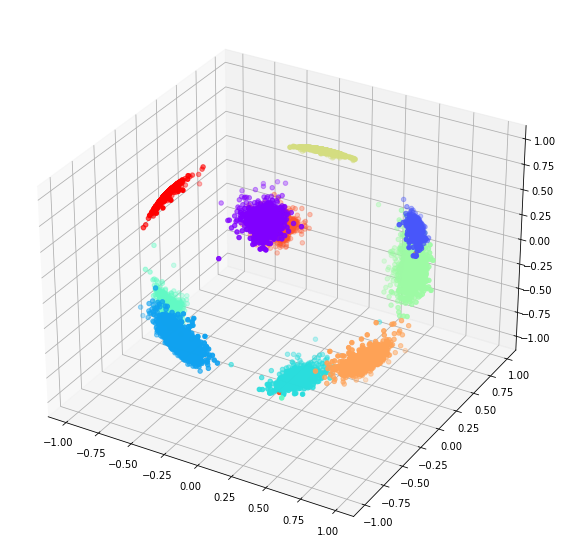

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

label = tf.argmax(train_y, axis=1)
colors = cm.rainbow(np.linspace(0, 1, 10))

fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(111, projection="3d")
for i in range(10):
    x = embeddings[label==i][:, 0]
    y = embeddings[label==i][:, 1]
    z = embeddings[label==i][:, 2]
    ax0.scatter(x, y, z, color=colors[i])

## softmax loss

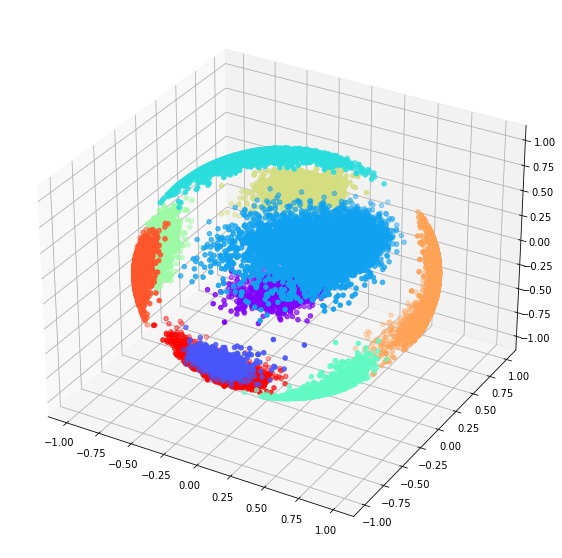

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

label = tf.argmax(train_y, axis=1)
colors = cm.rainbow(np.linspace(0, 1, 10))

fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(111, projection="3d")
for i in range(10):
    x = embeddings[label==i][:, 0]
    y = embeddings[label==i][:, 1]
    z = embeddings[label==i][:, 2]
    ax0.scatter(x, y, z, color=colors[i])